In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install h5py

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [72]:
import numpy as np
import h5py
import os
import random
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image

from os import path as osp
from k12libs.utils.nb_easy import K12AI_NBDATA_ROOT

# NYU Depth V2 Dataset

## Split Train & Test Data

In [4]:
data = sio.loadmat(osp.join(K12AI_NBDATA_ROOT, 'splits.mat'))

In [5]:
train_idx = data['trainNdxs']
test_idx = data['testNdxs']
type(test_idx), test_idx[:5], \
len(train_idx), len(test_idx), \
train_idx[0], train_idx[0][0]

(numpy.ndarray,
 array([[ 1],
        [ 2],
        [ 9],
        [14],
        [15]], dtype=uint16),
 795,
 654,
 array([3], dtype=uint16),
 3)

In [6]:
nyu_mat = h5py.File(osp.join(K12AI_NBDATA_ROOT, 'nyu_depth_v2_labeled.mat'), 'r')

In [7]:
images = nyu_mat["images"]
depths = nyu_mat["depths"]
labels = nyu_mat["labels"]
accel =  nyu_mat['accelData']

In [8]:
len(images), len(depths), len(labels), len(accel), \
type(images), type(depths), type(labels), type(accel)

(1449,
 1449,
 1449,
 4,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset)

In [9]:
images = np.array(images)
depths = np.array(depths)
labels = np.array(labels)

type(images), type(depths), type(labels)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [71]:
nyu_root = osp.join(K12AI_NBDATA_ROOT, 'nyudepthv2')

## Train & Val Files

In [80]:
train_path = osp.join(nyu_root, 'train')
val_path = osp.join(nyu_root, 'val')

if not osp.isdir(train_path):
    os.makedirs(train_path) 
if not osp.isdir(val_path):
    os.makedirs(val_path) 
    
train_cnt = 0
val_cnt = 0
for idx in train_idx.ravel():
    f_idx = '{0:0>5}'.format(idx)
    if random.randint(0, 9) > 2:
        train_cnt += 1
        with h5py.File(osp.join(train_path, f_idx + '.h5'), 'w') as h5f1:
            h5f1['rgb'] = np.transpose(images[idx-1], (0, 2, 1))
            h5f1['depth'] = np.transpose(depths[idx-1], (1, 0))
    else:
        val_cnt += 1
        with h5py.File(osp.join(val_path, f_idx + '.h5'), 'w') as h5f2:
            h5f2['rgb'] = np.transpose(images[idx-1], (0, 2, 1))
            h5f2['depth'] = np.transpose(depths[idx-1], (1, 0))
train_cnt, val_cnt

(567, 228)

## Test Files

In [12]:
test_path = osp.join(nyu_root, 'test')
if not osp.isdir(test_path):
    os.makedirs(test_path) 
for idx in test_idx.ravel():
    f_idx = '{0:0>5}'.format(idx)
    with h5py.File(osp.join(test_path, f_idx + '.h5'), 'w') as h5f:
        h5f['rgb'] = np.transpose(images[idx-1], (0, 2, 1))
        h5f['depth'] = np.transpose(depths[idx-1], (1, 0))

In [32]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()                                                                  
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx                                                    
class_to_idx = find_classes(train_path)

In [39]:
IMG_EXTENSIONS = ['.h5', ]                                                   
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)
def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            if is_image_file(d):
                path = d
                item = (path, 0)
                images.append(item)
        else:
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    if is_image_file(fname):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target])
                        images.append(item)
    return images
make_dataset(train_path, class_to_idx)[:5]

[('/data/nb_data/nyudepthv2/train/00003.h5', 0),
 ('/data/nb_data/nyudepthv2/train/00004.h5', 0),
 ('/data/nb_data/nyudepthv2/train/00005.h5', 0),
 ('/data/nb_data/nyudepthv2/train/00006.h5', 0),
 ('/data/nb_data/nyudepthv2/train/00007.h5', 0)]

## Show Image

In [13]:
images.shape, depths.shape, labels.shape, \
images.min(), images.max(), depths.min(), depths.max(), labels.min(), labels.max()

((1449, 3, 640, 480),
 (1449, 640, 480),
 (1449, 640, 480),
 0,
 255,
 0.7132995,
 9.99547,
 0,
 894)

In [14]:
images[0][0][300:305, 200:205], depths[0][300:305, 200:205], labels[0][300:305, 200:205]

(array([[194, 195, 194, 193, 192],
        [193, 194, 195, 194, 193],
        [192, 193, 195, 196, 195],
        [191, 193, 196, 197, 196],
        [194, 194, 193, 192, 192]], dtype=uint8),
 array([[3.3617222, 3.361722 , 3.3617222, 3.361722 , 3.3617222],
        [3.3617225, 3.3617225, 3.3617222, 3.361722 , 3.3617215],
        [3.3617222, 3.3617222, 3.3617222, 3.3617215, 3.3617182],
        [3.3617225, 3.3617215, 3.361722 , 3.3617215, 3.3617184],
        [3.3617222, 3.3617218, 3.3617167, 3.3617024, 3.361657 ]],
       dtype=float32),
 array([[21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21]], dtype=uint16))

### Raw RGB Image

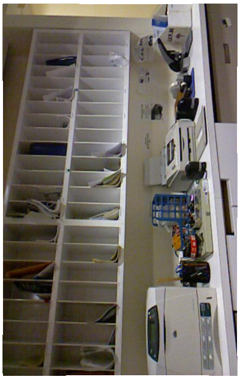

In [20]:
rgb_img0 = images[10]
rgb_img0 = rgb_img0.transpose((1, 2, 0))

Image.fromarray(np.uint8(rgb_img0)).resize((240, 380))

### Depth Map

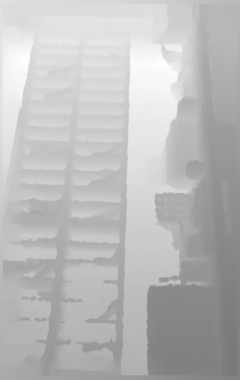

In [19]:
depth_img0 = depths[10]

depth_img0 = depth_img0 / depth_img0.max() * 255

Image.fromarray(np.uint8(depth_img0)).resize((240, 380))

### Label

In [23]:
labels[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)